In [7]:
# from DasTools import DasPrep as dp

# file = r'data\\DAS_20250423122300_20250423122330.h5'
# metadata = dp.read_das(file, metadata=True)
# dt = metadata['dt']
# dx = metadata['dx']

In [8]:
# from DasTools import DasPrep as dp
# import h5py
# import numpy as np
# from datetime import datetime

# def save_as_das_h5(data, output_path, dt=1/2000, dx=10, GL=10):
#     """
#     存储通道优先的DAS数据（shape=(1751,60000)），完全兼容_read_das_h5()
    
#     参数：
#     - data: 必须为(channels, time)格式的二维数组，shape=(1751,60000)
#     - output_path: 输出h5文件路径
#     - dt: 采样间隔（秒）
#     - dx: 道间距（米）
#     - GL: 标距（米）
#     """
#     nch, nt = data.shape  # 应验证是否为(1751,60000)
    
#     with h5py.File(output_path, 'w') as h5_file:
#         # 1. 创建Acquisition组和属性
#         acq = h5_file.create_group('Acquisition')
#         acq.attrs['NumberOfLoci'] = nch
#         acq.attrs['SpatialSamplingInterval'] = dx
#         acq.attrs['GaugeLength'] = GL
#         acq.attrs['CreationDate'] = datetime.now().isoformat()
        
#         # 2. 创建Raw[0]组
#         raw0 = acq.create_group('Raw[0]')
        
#         # 3. 关键修改：存储通道优先数据（无需转置）
#         raw0.create_dataset('RawData', 
#                           data=data,  # 直接存储，保持(channels, time)
#                           dtype=np.float32,
#                           chunks=(min(100, nch), min(1000, nt)),  # 优化读取性能
#                           compression="gzip")
        
#         # 4. 存储时间数据（微秒整型）
#         time_data = (np.arange(nt) * dt * 1e6).astype(np.int64)
#         raw0.create_dataset('RawDataTime',
#                           data=time_data,
#                           dtype=np.int64)
        
#         # 5. 添加维度说明属性
#         raw0.attrs['DimensionOrder'] = 'channels_first'  # 明确说明维度顺序

In [9]:
#转存h5
import numpy as np
import glob
import os


dt = 1/2000
dx = 0.01
fs = 1/dt

delay_range = (10, 15)



noise_files = glob.glob('data/*.h5')
signal_files = glob.glob('ev/*.npy')
assert len(noise_files) == len(signal_files), "noise和signal文件数量不匹配"

for noise_file, signal_file in zip(noise_files, signal_files):
    # 读取数据
    noise = dp.read_das(noise_file)
    xsmooth_final = np.load(signal_file)
    
    # 生成随机延迟
    random_delay = np.random.uniform(low=delay_range[0], high=delay_range[1])
    print(random_delay)
    delay_samples = int(random_delay * fs)
    
    # 应用延迟
    xsmooth_delayed = np.zeros_like(xsmooth_final)
    if delay_samples > 0:
        xsmooth_delayed[:, delay_samples:] = xsmooth_final[:, :-delay_samples]
    
    # 合并数据
    combined = xsmooth_delayed * 1e7    + noise*2  
    
    # 生成输出文件名
    noise_basename = os.path.basename(noise_file)
    output_name = os.path.splitext(noise_basename)[0] + '.h5'
    output_path = f'Zhoushan_combined_data/{output_name}'
    
    # 保存结果
    save_as_das_h5(combined, output_path)
    print(f'已处理并保存: {output_path}')

print("所有文件处理完成！")

所有文件处理完成！


# 同silixa格式

# 修改成通用高silixa格式

In [10]:
from scipy import signal as spsig
import numpy as np
import h5py
from datetime import datetime
import re
import glob
import os
import DasPrep as dp

def parse_time_from_filename(filename):
    """从文件名解析时间"""
    match = re.search(r'DAS_(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})', filename)
    if match:
        year, month, day, hour, minute, second = map(int, match.groups())
        return datetime(year, month, day, hour, minute, second)
    return datetime.now()

def save_as_das_h5(data, output_path, dt=0.01, dx=10, GL=10, noise_filename=None):
    nch, nt = data.shape
    
    # 自动计算最佳chunks大小
    chunk_nch = min(500, nch)  # 通道维度不超过500
    chunk_nt = min(1000, nt)   # 时间维度不超过1000
    chunks = (chunk_nch, chunk_nt)
    
    with h5py.File(output_path, 'w') as h5_file:
        
        # 时间属性
        start_time = parse_time_from_filename(noise_filename) if noise_filename else datetime.now()
        time_start = int(start_time.timestamp()*1e6 + start_time.microsecond)
        print(time_start)
        acq = h5_file.create_group('Acquisition')
        acq.attrs['NumberOfLoci'] = nch
        acq.attrs['SpatialSamplingInterval'] = dx
        acq.attrs['GaugeLength'] = GL
        acq.attrs['CreationDate'] = datetime.now().isoformat()
        
        # 2. 创建Raw[0]组
        raw0 = acq.create_group('Raw[0]')
        
        # 3. 关键修改：存储通道优先数据（无需转置）
        raw0.create_dataset('RawData', 
                          data=data,  # 直接存储，保持(channels, time)
                          dtype=np.float32,
                          chunks=(min(100, nch), min(1000, nt)),  # 优化读取性能
                          compression="gzip")
        
        # 4. 存储时间数据（微秒整型）
        time_data = (np.arange(nt) * dt * 1e6).astype(np.int64)
        time_data += time_start
        raw0.create_dataset('RawDataTime',
                          data=time_data,
                          dtype=np.int64)
        
        # 5. 添加维度说明属性
        raw0.attrs['DimensionOrder'] = 'channels_first'  # 明确说明维度顺序
        

# 合成phasenetDAS可检测的文件

In [11]:
# from scipy import signal as spsig
# import numpy as np
# import h5py
# from datetime import datetime
# import re
# import glob
# import os
# from DasTools import DasPrep as dp

# def parse_time_from_filename(filename):
#     """从文件名解析时间"""
#     match = re.search(r'DAS_(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})', filename)
#     if match:
#         year, month, day, hour, minute, second = map(int, match.groups())
#         return datetime(year, month, day, hour, minute, second)
#     return datetime.now()

# def save_as_das_h5(data, output_path, dt=0.01, dx=10, GL=10, noise_filename=None):
#     nch, nt = data.shape
    
#     # 自动计算最佳chunks大小
#     chunk_nch = min(500, nch)  # 通道维度不超过500
#     chunk_nt = min(1000, nt)   # 时间维度不超过1000
#     chunks = (chunk_nch, chunk_nt)
    
#     with h5py.File(output_path, 'w') as h5_file:
#         # 创建必要的组结构
#         acq = h5_file.create_group('Acquisition')
#         raw0 = acq.create_group('Raw[0]')
        
#         # 主数据集
#         raw_data = raw0.create_dataset(
#             'RawData',
#             data=data.astype(np.float32),
#             dtype=np.float32,
#             chunks=chunks,
#             compression="gzip",
#             compression_opts=6
#         )
        
#         # 设置属性
#         acq.attrs['SpatialSamplingInterval'] = dx
#         acq.attrs['GaugeLength'] = GL
#         raw0.attrs['OutputDataRate'] = 1/dt
        
#         # 时间属性
#         start_time = parse_time_from_filename(noise_filename) if noise_filename else datetime.now()
       
        
#         raw_data.attrs['PartStartTime'] = (start_time.isoformat(timespec='microseconds') + 'Z').encode()


In [12]:
import numpy as np
import glob
import os


dt = 1/100  # 目标采样间隔(100Hz)
original_fs = 2000  # 原始采样率
downsample_factor = int(original_fs // (1/dt)) # 降采样系数20

delays = [14.058091916080729,13.57291814660996,14.235243997802293,
          11.968245213127593,12.736030149587574,12.13520766648479,
          11.598989624155458,14.975595959535404,13.815460737644667,
          13.40766044558874,10.35397328218568,11.691783512582948,
          12.744438064055633,13.038127106356042,12.030241062789061,
          12.707406678207299,10.10346863980534,11.022839543601965,
          11.926082996079373,11.100721481994613]


noise_files = glob.glob('./noise/*.h5')
signal_files = sorted(glob.glob('./signal/*.npy'), 
                     key=lambda x: int(re.search(r'wavefield_(\d+)', x).group(1)))

for i, delay in enumerate(delays):
    # 1. 读取原始数据(2000Hz)
    noise = dp.read_das(noise_files[i])
    signal = np.load(signal_files[i])
    
    # 2. 统一截断长度
    min_length = min(noise.shape[1], signal.shape[1])
    min_length = (min_length // downsample_factor) * downsample_factor  # 确保可整除
    noise = noise[:, :min_length]
    signal = signal[:, :min_length]
    
    # 3. 降采样到100Hz
    noise_resampled = spsig.decimate(noise, downsample_factor, axis=1)
    signal_resampled = spsig.decimate(signal, downsample_factor, axis=1)
    
    # 4. 应用延迟(按100Hz计算)
    delay_samples = int(delay * (1/dt))
    signal_delayed = np.zeros_like(signal_resampled)
    if delay_samples > 0:
        signal_delayed[:, delay_samples:] = signal_resampled[:, :-delay_samples]
    
    # 5. 合并数据
    combined = signal_delayed * 1e7 + noise_resampled / 2
    combined = combined.astype(np.float32)  # 保持float32类型
    
    # 6. 保存结果
    output_path = f"./DAS_data/{os.path.basename(noise_files[i])}"

    # output_path = f"I:\\zhoushan_data\\Zhoushan_synthetic_data\\DAS_data\\{os.path.basename(noise_files[i])}"
    save_as_das_h5(combined, output_path, dt=dt, noise_filename=noise_files[i])
    print(f"已处理并保存: {output_path} (形状: {combined.shape})")

1745382180000000
已处理并保存: ./DAS_data/DAS_20250423122300_20250423122330.h5 (形状: (1751, 3000))
1745382210000000
已处理并保存: ./DAS_data/DAS_20250423122330_20250423122400.h5 (形状: (1751, 3000))


IndexError: list index out of range

In [ ]:
sorted_files

['ev\\DAS_wavefield_1_10_10.npy',
 'ev\\DAS_wavefield_2_15_10.npy',
 'ev\\DAS_wavefield_3_20_10.npy',
 'ev\\DAS_wavefield_4_30_10.npy',
 'ev\\DAS_wavefield_5_35_10.npy',
 'ev\\DAS_wavefield_6_40_10.npy',
 'ev\\DAS_wavefield_7_10_20.npy',
 'ev\\DAS_wavefield_8_20_20.npy',
 'ev\\DAS_wavefield_9_30_20.npy',
 'ev\\DAS_wavefield_10_40_20.npy',
 'ev\\DAS_wavefield_11_10_30.npy',
 'ev\\DAS_wavefield_12_20_30.npy',
 'ev\\DAS_wavefield_13_30_30.npy',
 'ev\\DAS_wavefield_14_40_30.npy',
 'ev\\DAS_wavefield_15_10_40.npy',
 'ev\\DAS_wavefield_16_20_40.npy',
 'ev\\DAS_wavefield_17_30_40.npy',
 'ev\\DAS_wavefield_18_40_40.npy',
 'ev\\DAS_wavefield_19_25_30.npy',
 'ev\\DAS_wavefield_20_35_30.npy']

In [ ]:
xsmooth_final.std() * 1e7  

0.022657431530460206

In [ ]:
noise.std()*2

0.27788057923316956

(10.0, 20.0)

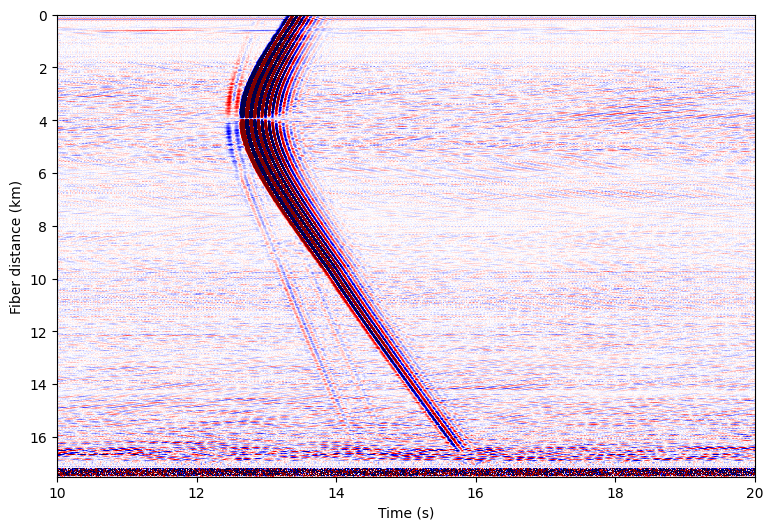

In [ ]:



file = r'DAS_data/DAS_20250423122430_20250423122500.h5'
combined_read = dp.read_das(file)


import matplotlib.pyplot as plt

plt.figure(figsize=[9,6])



data_plot = combined_read[:, :]

####
clim = data_plot.std()/5
####

extent=[0, data_plot.shape[1]*dt, data_plot.shape[0]*dx, 0]
plt.imshow(data_plot, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim, extent=extent)
plt.ylabel('Fiber distance (km)')
plt.xlabel('Time (s)')

plt.xlim(10,20)